In [228]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.optimize import minimize, fmin
from sklearn.metrics import mean_squared_error, mean_absolute_error
%matplotlib inline

In [216]:
PATH = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv'
series = pd.read_csv(PATH)['Sales']

In [217]:
series = boxcox(series, 0)
series_orig = series.copy()
series = series[1:] - series[:-1]
series = series[1:] - series[:-1]

Для начала применим скользящее среднее для обоих рядов.

In [298]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

def moving_plot(series, n):
    ser = moving_average(series, n)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 5))
        plt.plot(series, color='blue',label='original')
        plt.plot(ser, color='red', linewidth='4', label='Moving Average')
        plt.legend()

Оригинальный ряд:

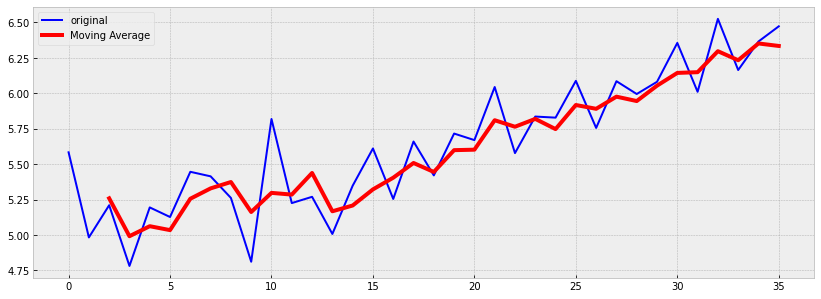

In [299]:
moving_plot(series_orig, 3)

Стационарный:

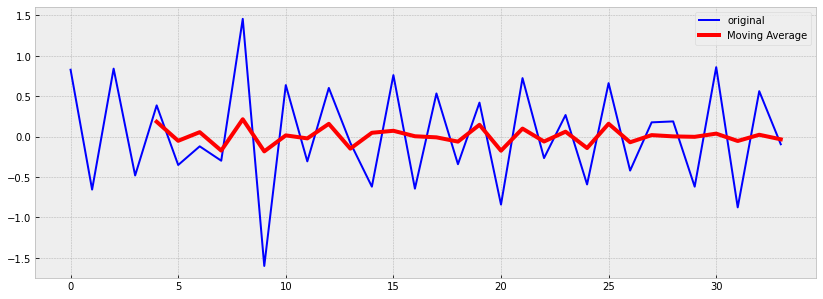

In [300]:
moving_plot(series, 5)

А теперь экспоненциальное сглаживание.

In [295]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

def exp_moving_plot(series, n):
    ser = exponential_moving_average(series, n)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 5))
        plt.plot(series, color='blue',label='original')
        plt.plot(ser, color='red', linewidth='4', label='Moving Average')
        plt.legend()

Для оригинального ряда:

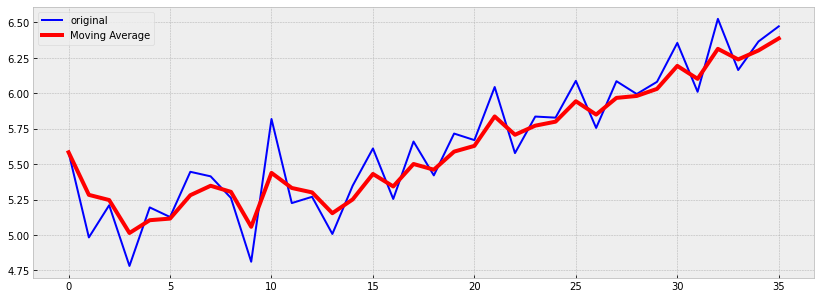

In [296]:
exp_moving_plot(series_orig, .5)

И для стационарного:

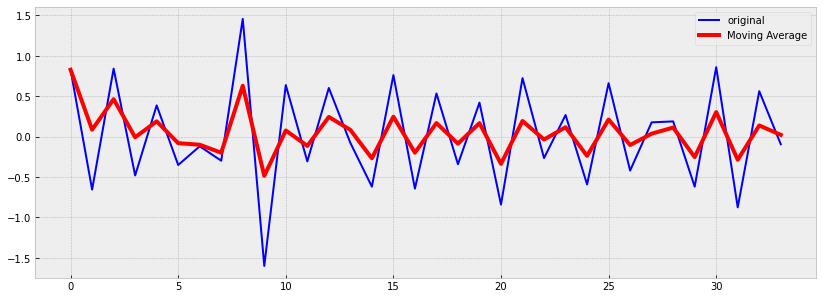

In [297]:
exp_moving_plot(series, .5)

Непохоже, что в ряде есть какая-то сезонность, поэтому теперь воспользуемся алгоритмом лишь с трендом и уровнем. Например, двойным экспоненциальным сглаживанием. 

In [213]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

def plot_dema(series, alpha, beta):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 5))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

Оригинальный ряд:

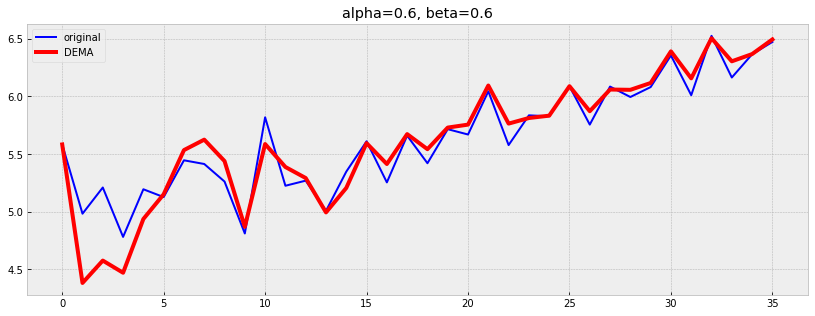

In [214]:
plot_dema(series_orig, 0.6, 0.6)

А теперь применим алгоритм к стационарному ряду:

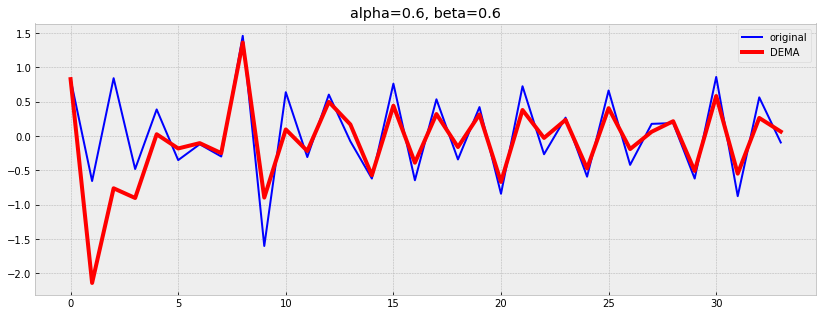

In [215]:
plot_dema(series, 0.6, 0.6)

Далее из интереса попробуем воспользоваться алгоритмом, спрогнозировав несколько наблюдений. $\alpha$ и $\beta$ будем подбирать методом TNC, минимизируя MAE.

In [301]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return pd.Series(result)

def mse(X):
    alpha, beta = X
    result = double_ema_with_preds(train, alpha, beta, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

def mae(X):
    alpha, beta = X
    result = double_ema_with_preds(train, alpha, beta, len(test))
    predictions = result[-len(test):]
    error = mean_absolute_error(predictions, test)
    return error

def plot_tema(alpha, beta, ser=series, ser_to_plot=series, n_preds=5):
    tema = double_ema_with_preds(ser, alpha, beta, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 5))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

Для оригинального ряда имеем следующую картину:

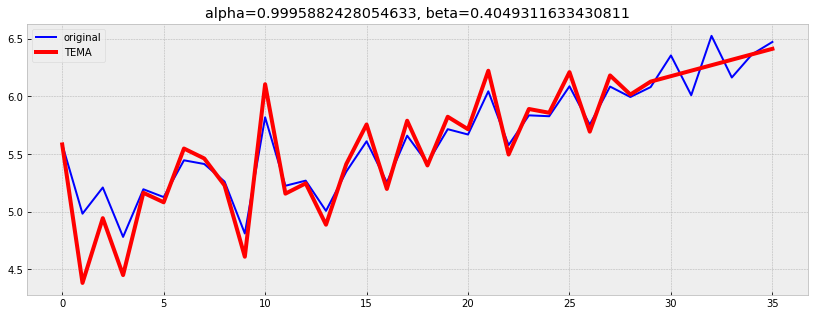

In [302]:
train, test = series_orig[:num], series_orig[num:]
opt = minimize(mae, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))
alpha_opt, beta_opt = opt.x
plot_tema(alpha_opt, beta_opt, ser=train, ser_to_plot=series_orig, n_preds=len(test))

Кажется, будто мы слишком подогнали данные под обучающие данные. Поэтому выберем гиперпараметры вручную.

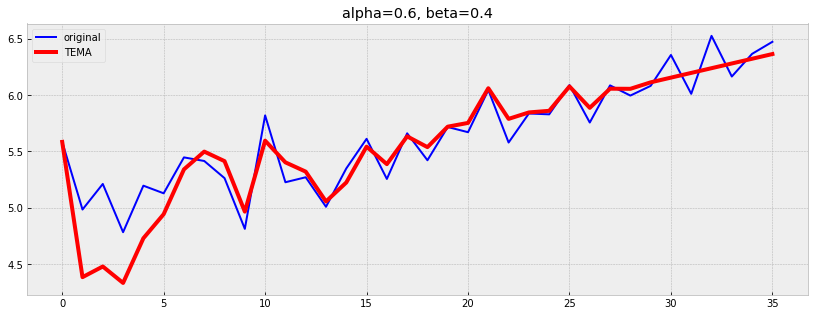

In [303]:
plot_tema(.6, .4, ser=train, ser_to_plot=series_orig, n_preds=len(test))

Немного, но лучше.

Теперь черед стационарного ряда:

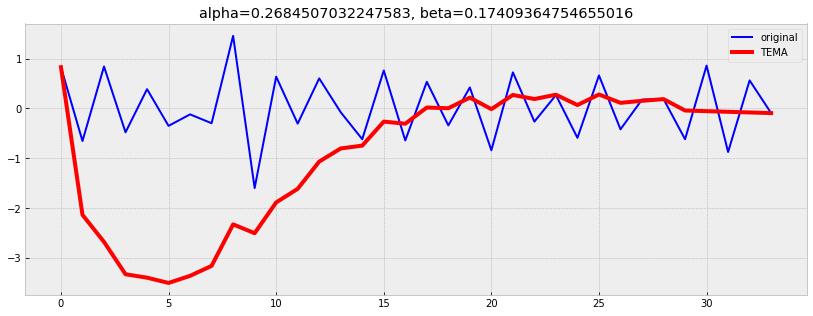

In [304]:
num = 30
train, test = series[:num], series[num:]
opt = minimize(mae, x0=[0,0], method="TNC", bounds = ((0, 1), (0, 1)))
alpha_opt, beta_opt = opt.x
plot_tema(alpha_opt, beta_opt, ser=train, ser_to_plot=series, n_preds=len(test))

В начале наше приближение сильно проседает, но после приходит в норму. Предсказания также показывают правдоподобный тренд.